In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./dl-assets-pricing")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

from preprocess_data import next_month, Dataset, train_val_split, batchify
from train import trainmodel, check_accuracy
from losses import pricing_error, time_series_variation
from torch.utils.data.dataloader import DataLoader
from fama_french_helper import ff_returns
from metrics import compute_Rts, compute_PE, compute_CS 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from model import DeepCharacteristics, SortedFactorModel

## Load Data

In [4]:
ff_factors_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/fama_french_factors.csv'
ff_ptf_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios.csv'
firm_carac = pd.read_csv("C:/Users/Raach/Desktop/3A/Projet MDS/S2000_3300HighestCap.csv")
firm_carac["be"] = firm_carac["be"]*1e6
ff_portfolio = pd.read_csv(ff_ptf_file)
ff_portfolio = ff_portfolio[ff_portfolio["date"].notnull()]
fff = pd.read_csv(ff_factors_file)
for df in [firm_carac,
           ff_portfolio,
           fff]:
        if type(df["date"].iloc[0]) == str:
            df["date"] = df["date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
        df["date"] = df["date"].apply(lambda x: x.replace(day=1))

In [5]:
firm_carac["be"] = firm_carac["be"] / 1e9
firm_carac["me"] = firm_carac["me"] / 1e9
firm_carac["BtM"] = firm_carac["be"]/firm_carac["me"]

In [6]:
current_month = dt.datetime(2000, 1, 1)
start_date = current_month
firm_characteristics = []
firm_returns = []
benchmark_factors = []
portfolios_returns = []
while current_month <= dt.datetime(2021, 12, 31):
    m_fc = firm_carac[(firm_carac["date"] == current_month) & (firm_carac["is_valid"])
                      ].sort_values("me", ascending=False).iloc[:2300]
    assert len(m_fc) == 2300
    firm_characteristics.append(m_fc[["retx", "me", "be"]].to_numpy())
    firm_returns.append(m_fc["retx"].to_numpy())
    benchmark_factors.append(fff[fff["date"] == current_month][["mktrf", "smb", "hml", "rf"]].to_numpy())
    portfolios_returns.append((ff_portfolio[ff_portfolio["date"] == current_month][[
                              k for k in ff_portfolio.keys() if "vwret" in k]]).to_numpy())
    current_month = next_month(current_month)
current_month = current_month-dt.timedelta(1)
firm_characteristics = np.stack(firm_characteristics)
firm_returns = np.stack(firm_returns)
benchmark_factors = np.stack(benchmark_factors).squeeze(axis=1)
portfolios_returns = np.stack(portfolios_returns).squeeze(axis=1)
portfolios_excess_returns = portfolios_returns - benchmark_factors[:,-1][:, None]
ds = Dataset(firm_characteristics[:, :, [1, 2]], firm_returns, benchmark_factors[:, [0, 2]], portfolios_excess_returns, start_date=start_date, end_date=current_month)

In [21]:
ptf_dict = ff_returns(ff_ptf_file, ff_factors_file, start_date, current_month, factors=["mktrf", "hml"])
ff3_coefs = pd.DataFrame.from_dict(ptf_dict)

In [22]:
ff3_coefs

,smlo,smme,smhi,bilo,bime,bihi
const,-0.001305,0.002842,0.005165,0.001042,0.001865,0.000169
mktrf,1.436448,1.156232,1.111091,1.172560,1.061834,1.211756
hml,-0.430999,0.190790,0.420701,-0.200569,0.446377,0.786664


In [9]:
train_set, val_set = train_val_split(ds)
batch_size = 5
trainloader = batchify(train_set, batch_size)
valloader = batchify(val_set, batch_size)

Validation data on time range: 2017-09-01 to 2021-12-31


## Design and train model

In [10]:
lambda_ = 10
def loss(gt_returns, pred_returns):
        return lambda_ * pricing_error(gt_returns, pred_returns) + time_series_variation(gt_returns, pred_returns)

In [11]:
network = SortedFactorModel(2, 2, 4, n_deep_factors=1, n_BM_factors=2, n_portfolio=6, ranking_method="softmax")

In [12]:
network, train_loss, val_loss = trainmodel(network, loss, trainloader, valloader, None, None, 50, weight_decay=0.1,
               loss_every=5, learning_rate=0.001)

Epoch     0/   50, loss = -1.0000, val_loss = 0.017434


 10%|█████████████▌                                                                                                                          | 5/50 [00:19<02:51,  3.81s/it]

Epoch     5/   50, loss = 0.007243, val_loss = 0.010013


 20%|███████████████████████████                                                                                                            | 10/50 [00:39<02:39,  4.00s/it]

Epoch    10/   50, loss = 0.003630, val_loss = 0.005373


 30%|████████████████████████████████████████▌                                                                                              | 15/50 [00:57<02:08,  3.67s/it]

Epoch    15/   50, loss = 0.001932, val_loss = 0.003003


 40%|██████████████████████████████████████████████████████                                                                                 | 20/50 [01:15<01:48,  3.61s/it]

Epoch    20/   50, loss = 0.001792, val_loss = 0.003455


 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 25/50 [01:34<01:30,  3.63s/it]

Epoch    25/   50, loss = 0.000792, val_loss = 0.001758


 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 30/50 [01:52<01:13,  3.66s/it]

Epoch    30/   50, loss = 0.000642, val_loss = 0.001344


 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 35/50 [02:10<00:53,  3.60s/it]

Epoch    35/   50, loss = 0.000689, val_loss = 0.001102


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 40/50 [02:28<00:35,  3.58s/it]

Epoch    40/   50, loss = 0.000582, val_loss = 0.001165


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 45/50 [02:46<00:17,  3.58s/it]

Epoch    45/   50, loss = 0.000576, val_loss = 0.000969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:05<00:00,  3.71s/it]

Epoch    50/   50, loss = 0.000515, val_loss = 0.000729


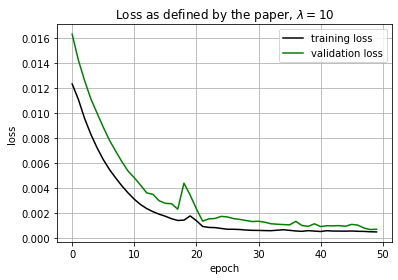

In [13]:
plt.plot(train_loss, label="training loss", color="black")
plt.plot(val_loss, label="validation loss", color="g")
plt.title(r"Loss as defined by the paper, $\lambda = 10$")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend();

## Test on same training portfolio but different time scope

In [14]:
data = batchify(val_set, len(val_set))[0]
Z, r, g, R = data
R_p, f = network.forward(Z, r, g)
g = g.detach().numpy()
betas = torch.concat([network.gamma, network.beta], axis=1)

In [15]:
print(f"Time series R: {compute_Rts(R, R_p):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_p)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, np.random.randn(18).reshape(6,3))}")

Time series R: 0.95037
Pricing error PE (1e-5): 0.38116
Cross sectional R: 0.8789686233353688


In [24]:
g_aug = np.concatenate([np.ones([g.shape[0], 1]), g], axis=1)
R_2f = g_aug @ ff3_coefs.to_numpy()
print(f"Time series R: {compute_Rts(R, R_2f):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_2f)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, ff3_coefs.to_numpy().T)}")

Time series R: 0.86222
Pricing error PE (1e-5): 3.28411
Cross sectional R: 0.9328430757685438


In [25]:
from scipy.stats import pearsonr

In [26]:
f_pred = f.detach().numpy().reshape(-1)
f_gt = benchmark_factors[-len(val_set):, 1]
pearsonr(f_gt, f_pred)

(-0.8072257158932712, 8.388687748580342e-13)

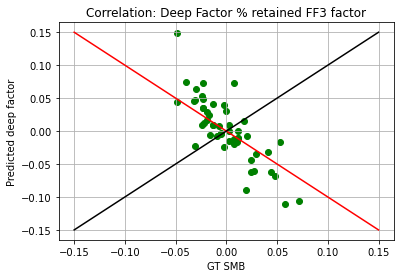

In [28]:
plt.scatter(f_gt, f_pred, color='g')
plt.plot([-0.15,0.15], [0.15,-0.15], color='r')
plt.plot([-0.15,0.15], [-0.15,0.15], color='black')
plt.xlabel("GT SMB")
plt.ylabel("Predicted deep factor")
plt.title("Correlation: Deep Factor % retained FF3 factor")
plt.grid();

In [29]:
print("Regression coef. with deep factor:")
print("portfolio name:", "'smlo', 'smme', 'smhi', 'bilo', 'bime','bihi'")
print("          ", [f"{x:.3f}" for x in list(network.beta.detach().numpy().flatten())])

Regression coef. with deep factor:
portfolio name: 'smlo', 'smme', 'smhi', 'bilo', 'bime','bihi'
           ['-0.552', '-0.499', '-0.542', '0.087', '-0.032', '0.036']


In [30]:
x = torch.abs((R_p-R)/R).flatten().detach().numpy() * 100
x = x[x<200]

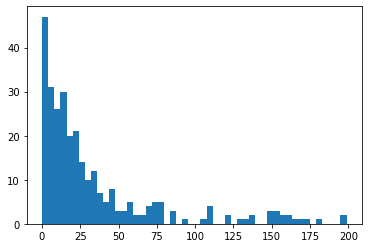

In [31]:
h, b, _ = plt.hist(x, bins=50)

In [32]:
np.median(x)

18.879385

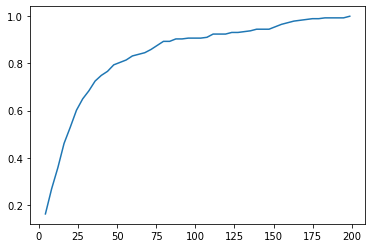

In [33]:
pdf = h/h.sum()
cdf = np.cumsum(pdf)
plt.plot(b[1:], cdf)

## Test on different training portfolio but different time scope

In [34]:
start_date = dt.datetime(2017,10,1)
pf25 = pd.read_csv('C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios25.csv')
pf6 = pd.read_csv('C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios.csv')
pf25 = pf25[pf25["date"].notnull()]
pf6 = pf6[pf6["date"].notnull()]
fff = fff[fff["date"].notnull()]
for df in [pf25,
           pf6,
          fff]:
    if type(df["date"].iloc[0]) == str:
        df["date"] = df["date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
        df["date"] = df["date"].apply(lambda x: x.replace(day=1))
pf25 = pf25[(pf25["date"]>=start_date) & (pf25["date"]<=current_month)]
pf6 = pf6[(pf6["date"]>=start_date) & (pf6["date"]<=current_month)]
fff = fff[(fff["date"]>=start_date) & (fff["date"]<=current_month)]

In [35]:
## Predict deep factor
data = batchify(val_set, len(val_set))[0]
Z, r, g, _ = data
_, f = network.forward(Z, r, g)

In [36]:
R = pf25[[k for k in pf25.keys() if "vwret"in k]].to_numpy()-fff["rf"].to_numpy()[:, None]

In [37]:
fff["deep_f"] = f.detach().numpy().flatten()
fff.to_csv("test_factors.csv")

C:\Users\Raach\AppData\Local\Temp/ipykernel_36980/2733650600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fff["deep_f"] = f.detach().numpy().flatten()


In [38]:
ff_ptf_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios25.csv'
ptf_dict = ff_returns(ff_ptf_file, ff_factors_file, start_date, current_month, factors=["mktrf", "smb", "hml"])
ff3_coefs = pd.DataFrame.from_dict(ptf_dict)
g = fff[["mktrf", "smb", "hml"]].to_numpy()
g_aug = np.concatenate([np.ones([g.shape[0], 1]), g], axis=1)
R_3f = g_aug @ ff3_coefs.to_numpy()
print(f"Time series R: {compute_Rts(R, R_3f):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_3f)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, ff3_coefs.to_numpy().T)}")

Time series R: 0.91359
Pricing error PE (1e-5): 0.35161
Cross sectional R: 0.9663279947282789


In [39]:
ff_ptf_file = 'C:/Users/Raach/Desktop/3A/Projet MDS/ff_portfolios25.csv'
ff_factors_file = "test_factors.csv"
ptf_dict = ff_returns(ff_ptf_file, ff_factors_file, start_date, current_month, factors=["mktrf", "deep_f", "hml"])
ff3_coefs = pd.DataFrame.from_dict(ptf_dict)
g = fff[["mktrf", "deep_f", "hml"]].to_numpy()
g_aug = np.concatenate([np.ones([g.shape[0], 1]), g], axis=1)
R_2f1d = g_aug @ ff3_coefs.to_numpy()
print(f"Time series R: {compute_Rts(R, R_2f1d):.5f}")
print(f"Pricing error PE (1e-5): {compute_PE(R, R_2f1d)*1e5:.5f}")
print(f"Cross sectional R: {compute_CS(R, ff3_coefs.to_numpy().T)}")

Time series R: 0.88747
Pricing error PE (1e-5): 0.35161
Cross sectional R: 0.9662455177480691


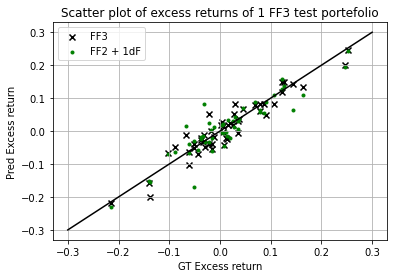

In [40]:
plt.scatter(R[:,0], R_3f[:,0], marker='x', label="FF3", color="black")
plt.scatter(R[:,0], R_2f1d[:,0], marker='.', label="FF2 + 1dF", color="green")
plt.plot([-0.3,0.3], [-0.3,0.3], 'black')
plt.legend()
plt.xlabel("GT Excess return")
plt.ylabel("Pred Excess return")
plt.grid()
plt.title("Scatter plot of excess returns of 1 FF3 test portefolio");